## Perceptrón multicapa

En esta parte de la práctica vamos a crear una red neuronal profunda, definiendo:
- la capa de entrada, 
- las capas ocultas, 
- una capa de dropout para mejorar los resultados y evitar overfitting 
- y, finalmente, la capa de salida.

Con la librería keras_tuner, vamos a optimizar la estructura de la red neural, ya que, vamos a seleccionar el número óptimo de neuronas, el número de capas ocultas y la cantidad de dropout a aplicar. Y todo ello de manera automática.

Vamos a analizar distintos métodos para realizar la optimización de los hiperparámetros (Hyperband, Random search y Bayesian Optimization), viendo cómo funciona cada uno de ellos y comparando los resultados.

En primer lugar realizamos las importaciones necesarias y cargando los sets de datos.

In [33]:
#!pip install keras_tuner
#!pip install tensorflow

In [4]:
#!pip install scikit-learn

     ---------------------------------------- 8.3/8.3 MB 14.7 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.3 MB/s eta 0:00:00


In [34]:
# Importamos las librerías necesarias.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split


In [6]:
# Importamos los datos de test, train y val.
X_train = pd.read_csv("./DatosPisaSinNan/X_train.csv", sep=',', decimal='.')
y_train = pd.read_csv("./DatosPisaSinNan/y_train.csv", sep=',', decimal='.')
X_val = pd.read_csv("./DatosPisaSinNan/X_val.csv", sep=',', decimal='.')
y_val = pd.read_csv("./DatosPisaSinNan/y_val.csv", sep=',', decimal='.')
X_test = pd.read_csv("./DatosPisaSinNan/X_test.csv", sep=',', decimal='.')
y_test = pd.read_csv("./DatosPisaSinNan/y_test.csv", sep=',', decimal='.')



In [7]:
from sklearn import preprocessing

#scaler = preprocessing.StandardScaler().fit(X_train)
scaler = preprocessing.Normalizer().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train/1000
y_val = y_val/1000
y_test = y_test/1000


Definimos la función que va a probar las distintas combinaciones de hyperparámetros que le indiquemos.
Esta función equivale a un GridSearch por fuerza bruta, donde probaremos varios valores de capas, número de neuronas, de dropout y learning rate.
Lo interesante es que vamos optimizar la búsqueda de hiperparametros utilizando tres tipos distintos de optimizadores que nos ofrece keras_tuner, como son: hyperband, random search y bayesian optimization.

Para facilitar el cómputo, sólo se ha implementado una capa 

In [8]:


def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=4, max_value=16, step=4)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=3, step=1)

    # Tuning del Dropout
    hp_droupout = hp.Float('dropout',min_value=0.0,max_value=0.5, step=0.1)
    
    # Input layer
    model.add(layers.Dense(units=16, activation='relu', input_shape=(X_test.shape[1],)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
          
    # Dropout layer
    model.add(layers.Dropout(hp_droupout))

    # Output layer
    #model.add(layers.Dense(1, activation=None))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001] del lr
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Compilamos el modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        loss= 'mse',
        metrics= ['mse']
    )
    
    return model

Creamos un callbacks que finalice el entrenamiento cuando las métricas monitoreadas empeoren.

In [9]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Metrica a monitorear
        monitor = 'val_loss',

        # Numero de iteraciones sin mejora en la validacion (indicado en 'val_loss')
        # antes de finalizar entrenamiento
        patience=2
    )
]

### Hyperband

Hyperband primero ejecuta configuraciones aleatorias de hiperparámetros para una iteración o dos, luego selecciona qué configuraciones funcionan bien y luego continúa ajustando las mejores.

In [10]:
# Lanzamos el tuning
# Borrar el directorio hp_dir para reiniciarlo si overwrite es False
# Poner overwrite a False si quieres conservar el modelo optimizado.
tuner_hb = kt.Hyperband(
    model_builder,
    objective= 'mse',
    max_epochs=30,
    factor=3,
    seed=42,
    directory='hp_dir_hb',
    project_name='ANN_project_hb',
    overwrite = True 
)

In [11]:
# Ejecución del proceso de tuning
tuner_hb.search(
    X_train, 
    y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks= callbacks,
    verbose = 0
)

INFO:tensorflow:Oracle triggered exit


Obtenemos los mejores hiperparámetros para nuestro modelo

In [12]:
# Obtención de los hiperparámetros óptimos
best_hps_hb = tuner_hb.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps_hb.get('units'))
print("Layers:", best_hps_hb.get('layers'))
print("Dropout:", best_hps_hb.get('dropout'))

Units: 8
Layers: 2
Dropout: 0.0


Realizamos una evaluación de nuestro modelo optimizado con el set de test.

In [13]:
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
best_model_hb.evaluate(X_test, y_test)

111/111 [==============================] - 0s 716us/step - loss: 0.0026 - mse: 0.0026


[0.0025743236765265465, 0.0025743236765265465]

### Random Search

Como sugiere el nombre, este método de ajuste de hiperparámetros prueba aleatoriamente una combinación de hiperparámetros de un espacio de búsqueda determinado.

In [14]:
tuner_rs = kt.RandomSearch(
            model_builder,                 
            objective='mse', # 'val_loss'
            seed=42,
            max_trials=10,
            directory='hp_dir_rs',
            project_name='ANN_project_rs',
            overwrite = True )


In [15]:
tuner_rs.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks = callbacks, verbose=0)
best_model_rs = tuner_rs.get_best_models(num_models=1)[0]
mse = best_model_rs.evaluate(X_test, y_test)

INFO:tensorflow:Oracle triggered exit
111/111 [==============================] - 0s 754us/step - loss: 0.0026 - mse: 0.0026


In [16]:
# Podemos ver cuales han sido los mejores hiperparametros que ha seleccionado el modelo 
best_hyperband_rs = tuner_rs.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hyperband_rs.get('units'))
print("Layers:", best_hyperband_rs.get('layers'))
print("Dropout:", best_hyperband_rs.get('dropout'))

Units: 16
Layers: 1
Dropout: 0.0


Vamos a emplear la mejor estructura obtenida con el optimizador hyperband para entrenar nuestro modelo y ver qué resultados nos arroja.

In [25]:
model = tuner_hb.hypermodel.build(best_hps_hb)

history = model.fit(
    X_train,
    y_train,
    epochs = 30,
    validation_data = (X_val, y_val),
    verbose = 1, 
    callbacks = callbacks
)


val_mse_per_epoch = history.history["val_mse"]
best_epoch = val_mse_per_epoch.index(min(val_mse_per_epoch))+1

# Numero maximo de epoch usadas para entrenar el modelo
best_epoch

Epoch 1/30
360/360 [==============================] - 1s 1ms/step - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 2/30
360/360 [==============================] - 0s 978us/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 3/30
360/360 [==============================] - 0s 978us/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/30
360/360 [==============================] - 0s 998us/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/30
360/360 [==============================] - 0s 964us/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 6/30
360/360 [==============================] - 0s 980us/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 7/30
360/360 [==============================] - 0s 1ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 8/30
360/360 [==============================] - 0s 968us/ste

11

Podemos ver como han ido cambiando los valores de loss y val_loss durante el entrenamiento.
Se ve como el modelo ha convergido y no hay overfitting.

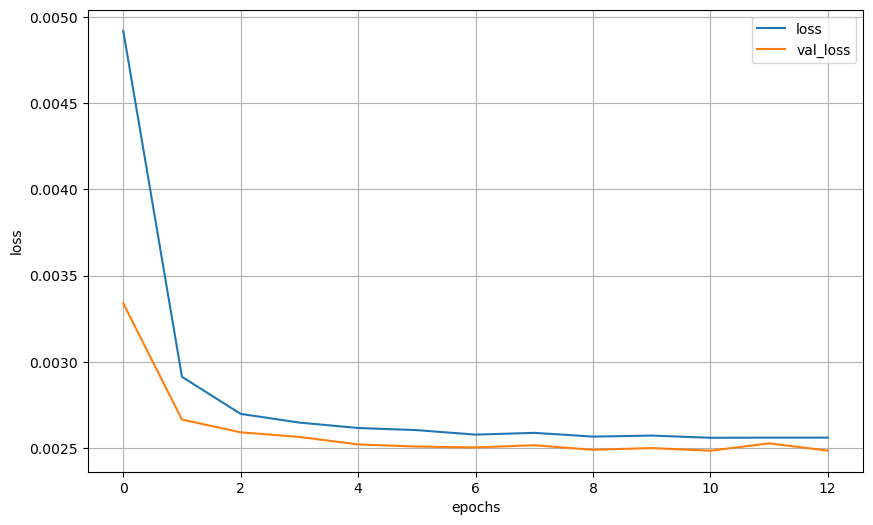

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Evaluamos nuestro modelo

In [28]:
model.evaluate(X_test, y_test)

111/111 [==============================] - 0s 760us/step - loss: 0.0026 - mse: 0.0026


[0.002577458741143346, 0.002577458741143346]

Deshacemos la normalización para obtener los valores reales de MSE y MAE. Con ellos, será más fácil evaluar el resultado de nuestro modelo.

In [29]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
print("MSE: ", mean_squared_error(y_test*1000, y_pred*1000))


111/111 [==============================] - 0s 644us/step
MSE:  2577.459104214213


In [30]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
print("MAE"":", mean_absolute_error(y_test*1000, y_pred*1000))

111/111 [==============================] - 0s 649us/step
MAE: 40.50450343780988


Nuestro modelo tiene un error absoluto de 41.33 con respecto a los valores reales.
Lo que le convierte a nuestro perceptrón multicapa en un predictor bastante bueno.